# MLP using PyTorch for image classification

### create  "signature":
#### The signature needs to be displayed right below the cell in this file

In [ ]:
import platform, socket, getpass
from time import time
from datetime import datetime
import random
signature_for_mlp=[socket.gethostbyname(socket.gethostname()),
                   getpass.getuser(),
                   datetime.now(),
                   random.random()]
print(signature_for_mlp)

['172.28.0.12', 'root', datetime.datetime(2025, 5, 9, 0, 49, 8, 459416), 0.6207222425394593]


In [ ]:
import torch
#sample code to save model and signature
#torch.save({"model":best_model_state,
            #"signature":signature_for_mlp},
            #"MLP_best.pt")

### This is a complete application of image classification using an MLP
steps: \
define an MLP \
define a function for training the MLP \
define a function for testing the MLP \
define a function for saving the model and your `signature_for_mlp` \
load data \
train the MLP in a for loop using the training set and the validation set\
evalaute the best model on the test set\
display accuracy and confusion matrix for each of the three sets: train, validation, and test sets


Signature: ['172.28.0.12', 'root', datetime.datetime(2025, 5, 9, 2, 25, 28, 100227), 0.4019705899429781]
Epoch 1 | Train Loss: 1.8216 | Val Accuracy: 57.50%
Epoch 2 | Train Loss: 0.9788 | Val Accuracy: 57.90%
Epoch 3 | Train Loss: 0.8257 | Val Accuracy: 70.90%
Epoch 4 | Train Loss: 0.6995 | Val Accuracy: 71.40%
Epoch 5 | Train Loss: 0.5947 | Val Accuracy: 75.80%
Epoch 6 | Train Loss: 0.5492 | Val Accuracy: 76.00%
Epoch 7 | Train Loss: 0.5093 | Val Accuracy: 73.40%
Epoch 8 | Train Loss: 0.4769 | Val Accuracy: 79.20%
Epoch 9 | Train Loss: 0.4126 | Val Accuracy: 80.50%
Epoch 10 | Train Loss: 0.4166 | Val Accuracy: 77.20%
Epoch 11 | Train Loss: 0.4107 | Val Accuracy: 78.00%
Epoch 12 | Train Loss: 0.3568 | Val Accuracy: 79.80%
Epoch 13 | Train Loss: 0.3323 | Val Accuracy: 80.20%
Epoch 14 | Train Loss: 0.3221 | Val Accuracy: 80.90%
Epoch 15 | Train Loss: 0.2919 | Val Accuracy: 82.30%
Epoch 16 | Train Loss: 0.2778 | Val Accuracy: 79.40%
Epoch 17 | Train Loss: 0.2626 | Val Accuracy: 82.30%
Epo

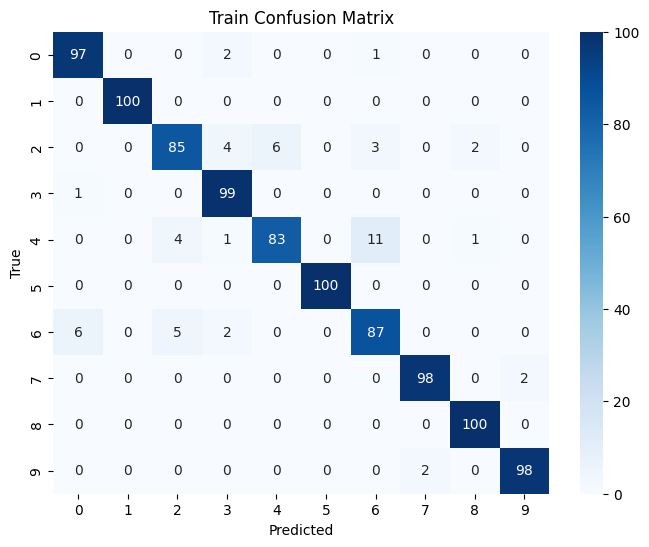

Validation Accuracy: 81.80%


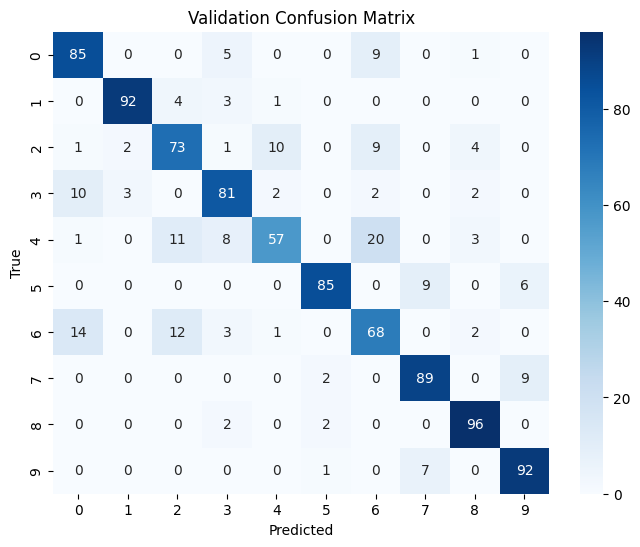

Test Accuracy: 79.20%


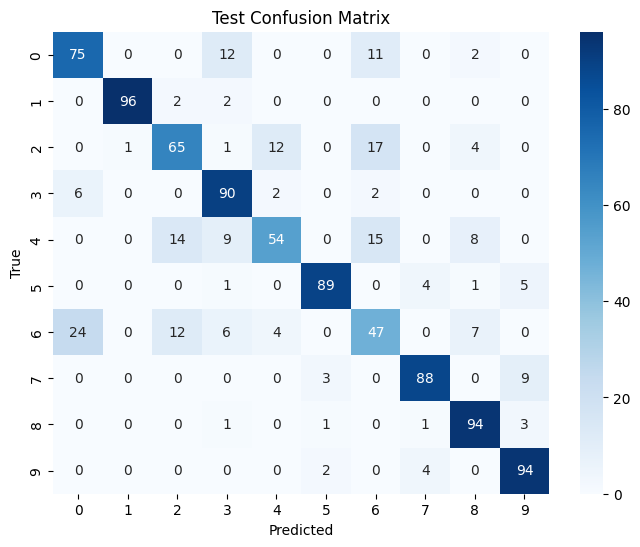

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import platform, socket, getpass
from datetime import datetime
import random

# Load dataset
data = torch.load("/content/H5T0_train_val_test_data.pt", weights_only=False)
X_train, y_train = torch.tensor(data['X_train']).float(), torch.tensor(data['Y_train']).long()
X_val, y_val = torch.tensor(data['X_val']).float(), torch.tensor(data['Y_val']).long()
X_test, y_test = torch.tensor(data['X_test']).float(), torch.tensor(data['Y_test']).long()

# Dataloaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

# MLP model definition
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

# Training and evaluation functions
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    preds, targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            _, predicted = torch.max(output, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            preds += predicted.cpu().tolist()
            targets += y_batch.cpu().tolist()
    return 100 * correct / total, preds, targets

# Signature
signature_for_mlp = [socket.gethostbyname(socket.gethostname()), getpass.getuser(), datetime.now(), random.random()]
print("Signature:", signature_for_mlp)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop with validation tracking
best_val_acc = 0
best_model_state = None

for epoch in range(1, 21):
    loss = train(model, train_loader, optimizer, criterion, device)
    val_acc, _, _ = evaluate(model, val_loader, device)
    print(f"Epoch {epoch} | Train Loss: {loss:.4f} | Val Accuracy: {val_acc:.2f}%")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()

# Save best model
torch.save({
    "model": best_model_state,
    "signature": signature_for_mlp
}, "MLP_best.pt")

# Load best model
model.load_state_dict(best_model_state)

# Evaluate on all splits and show confusion matrices
for name, loader in zip(["Train", "Validation", "Test"], [train_loader, val_loader, test_loader]):
    acc, preds, targets = evaluate(model, loader, device)
    print(f"{name} Accuracy: {acc:.2f}%")
    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [ ]:
import os
print("File exists:", os.path.exists("MLP_best.pt"))

File exists: True
